In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime

In [2]:
# Import data
flu = pd.read_csv('../data/INFLUENZA_sentinella/data.csv')
weather = pd.read_csv('../data/weather/reg_weather.csv')
google_flu = pd.read_csv('../data/google_search_trend/reg_google_grippe.csv')
google_symptoms = pd.read_csv('../data/google_search_trend/reg_google_fieber_husten.csv')
pop = pd.read_csv('../data/pop_data_cantons/weekly_imputed_pop_data_final.csv')

<h3>Data Preparation</h3>

In [3]:
flu.columns

Index(['valueCategory', 'temporal', 'temporal_type', 'georegion',
       'georegion_type', 'agegroup', 'agegroup_type', 'sex', 'value',
       'popExtrapolation', 'totalConsultationsExtrapolation', 'incValue',
       'prctConsultations', 'prct', 'trend', 'dataComplete'],
      dtype='object')

In [4]:
# Create dataframe for country-level observations, no differentiation between sex or age
flu_CH = flu.query('georegion_type == "country" and agegroup == "all" and sex == "all"').copy()

# Create dataframe for regional observations, no differentiation between sex or age
flu_reg = flu.query('georegion_type == "sentinella_region" and agegroup == "all" and sex == "all"').copy()

# Drop unknown region entries from flu_region using mask
flu_reg = flu_reg[~(flu_reg['georegion'] == 'unknown')]

# Select columns required for analysis
selected_cols = ['temporal', 'georegion', 'popExtrapolation', 'incValue', 'value']
flu_reg = flu_reg[selected_cols]
flu_reg.rename(columns={'popExtrapolation':'flu_cases'}, inplace=True)

In [5]:
# Align time-indexes of google data and flu data
with open('date_dict.json', 'r') as f:
    date_dict = json.load(f)

google_flu['Woche'] = google_flu['Woche'].apply(lambda x: date_dict[x])
google_symptoms['Woche'] = google_symptoms['Woche'].apply(lambda x: date_dict[x])

In [6]:
dates = weather.date.values
# Convert dates to 'YYYY-Www' ISO week format
iso_week_dates = [datetime.strptime(date, '%Y-%m-%d').isocalendar()[:2] for date in dates]
iso_week_dates = [f'{year}-W{week:02d}' for year, week in iso_week_dates]
weather['date'] = iso_week_dates

In [7]:
# Reshape google_flu from wide to long
google_flu = google_flu.melt(id_vars=['Woche'], var_name='region_query', value_name='search_activity')

# Separate region and query information from header into separate rows
google_flu['region'] = google_flu['region_query'].apply(lambda x: "_".join(x.split('_')[:2]))
google_flu['query'] = google_flu['region_query'].apply(lambda x: "_".join(x.split('_')[2:]))
google_flu.drop(columns='region_query', inplace=True) # Drop superfluous region_query column

# Reshape dataframe to get separate columns for each variable
google_flu = google_flu.pivot(index=['Woche', 'region'], columns='query', values='search_activity').reset_index()

In [8]:
# Reshape google_flu from wide to long
google_symptoms = google_symptoms.melt(id_vars=['Woche'], var_name='region_query', value_name='search_activity')

# Separate region and query information from header into separate rows
google_symptoms['region'] = google_symptoms['region_query'].apply(lambda x: "_".join(x.split('_')[:2]))
google_symptoms['query'] = google_symptoms['region_query'].apply(lambda x: "_".join(x.split('_')[2:]))
google_symptoms.drop(columns='region_query', inplace=True) # Drop superfluous region_query column

# Reshape dataframe to get separate columns for each variable
google_symptoms = google_symptoms.pivot(index=['Woche', 'region'], columns='query', values='search_activity').reset_index()

In [9]:
merged_data = pd.merge(flu_reg, weather, how='left', left_on=['temporal', 'georegion'], right_on=['date', 'region']).sort_values(by=['georegion', 'temporal'])
merged_google = pd.merge(google_flu, google_symptoms, how='inner', on=['region', 'Woche'])
merged_data = pd.merge(merged_data, merged_google, how='left', left_on=['georegion', 'temporal'], right_on=['region', 'Woche'])

In [10]:
merged_data.columns

Index(['temporal', 'georegion', 'flu_cases', 'incValue', 'value', 'region_x',
       'date', 'weighted_avg_daily_temp', 'weighted_avg_daily_hum',
       'weighted_max_daily_temp', 'weighted_min_daily_temp',
       'weighted_max_daily_hum', 'weighted_min_daily_hum', 'Woche', 'region_y',
       'Flu', 'Flu_resid', 'Flu_seasonal', 'Flu_trend', 'Grippe',
       'Grippe_resid', 'Grippe_seasonal', 'Grippe_trend', 'Influenza',
       'Influenza_resid', 'Influenza_seasonal', 'Influenza_trend', 'influenza',
       'influenza_resid', 'influenza_seasonal', 'influenza_trend', 'Fieber',
       'Fieber_resid', 'Fieber_seasonal', 'Fieber_trend', 'fièvre',
       'fièvre_resid', 'fièvre_seasonal', 'fièvre_trend', 'husten',
       'husten_resid', 'husten_seasonal', 'husten_trend', 'toux', 'toux_resid',
       'toux_seasonal', 'toux_trend'],
      dtype='object')

In [11]:
merged_data.drop(columns=['region_x', 'region_y', 'date', 'Woche'], inplace=True)

In [12]:
import datetime

# Functions taken from: https://stackoverflow.com/questions/304256/whats-the-best-way-to-find-the-inverse-of-datetime-isocalendar
def iso_year_start(iso_year):
    "The gregorian calendar date of the first day of the given ISO year"
    fourth_jan = datetime.date(iso_year, 1, 4)
    delta = datetime.timedelta(fourth_jan.isoweekday()-1)
    return fourth_jan - delta 

def iso_to_gregorian(iso_year, iso_week, iso_day):
    "Gregorian calendar date for the given ISO year, week and day"
    year_start = iso_year_start(iso_year)
    return year_start + datetime.timedelta(days=iso_day-1, weeks=iso_week-1)


In [13]:
# Define the regex pattern
pattern = r'W(\d{1,2})'

# Extract week number and year and convert to integer
merged_data['week_number'] = merged_data['temporal'].str.extract(pattern).astype(int)

merged_data['year'] = merged_data['temporal'].apply(lambda x: x.split('-')[0])
merged_data['year'] = pd.to_numeric(merged_data['year'])

# Convert from iso-calendar week to dates
merged_data['date'] = list(map(lambda year, week: iso_to_gregorian(year, week, 4), merged_data['year'], merged_data['week_number']))

In [14]:
# merged_data.set_index('date', inplace=True)

In [15]:
# Impute missing values in March 2020 linearly
merged_data['incValue'].interpolate(inplace=True)

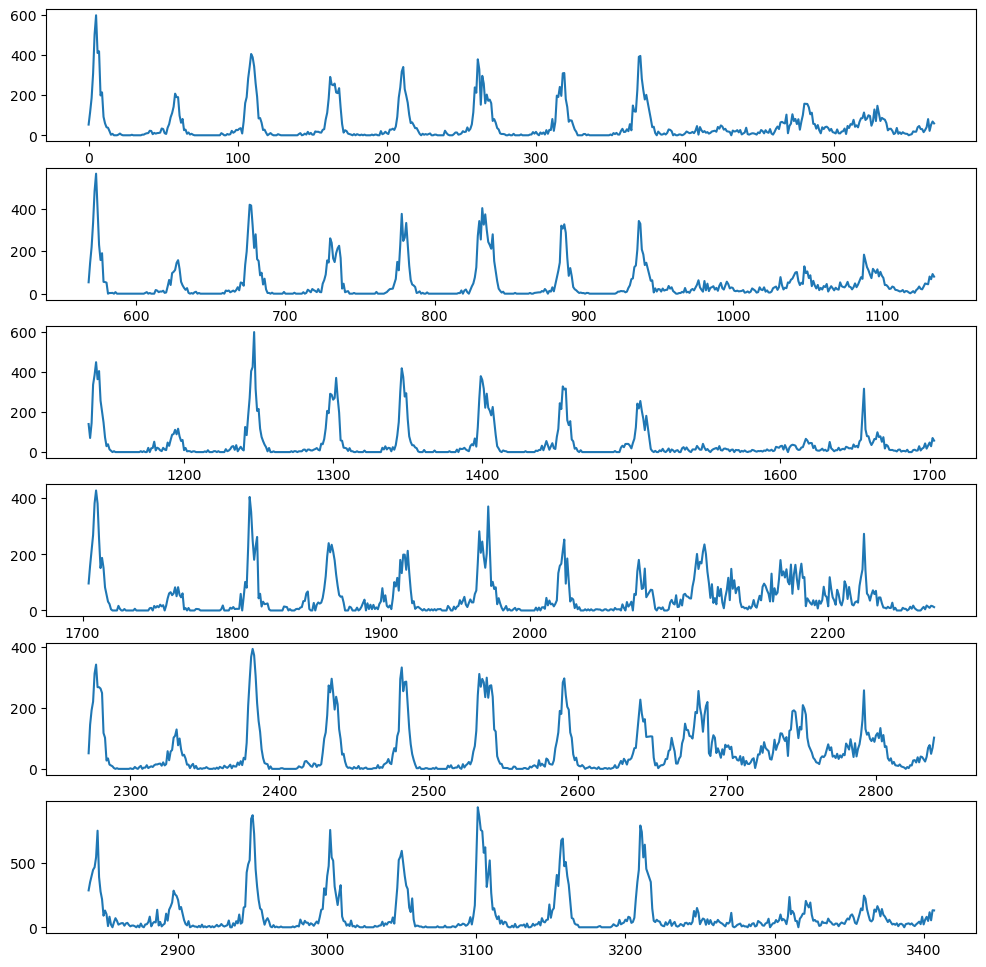

In [16]:
fig, ax = plt.subplots(6, figsize=(12, 12))
for i in range(1, 7):
    ax[i-1].plot(merged_data.loc[merged_data['georegion'] == f"region_{i}", 'incValue'])

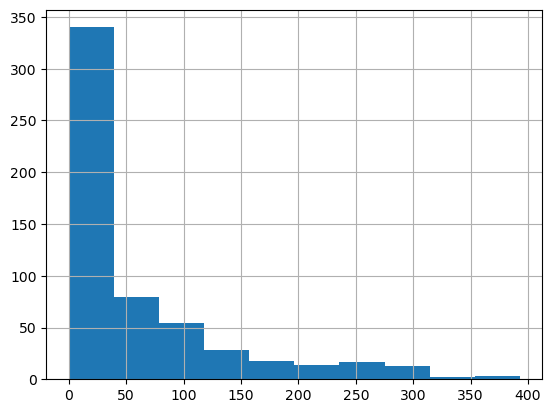

In [17]:
from matplotlib import pyplot
merged_data.loc[merged_data['georegion'] == "region_5", 'incValue'].hist()
pyplot.show()

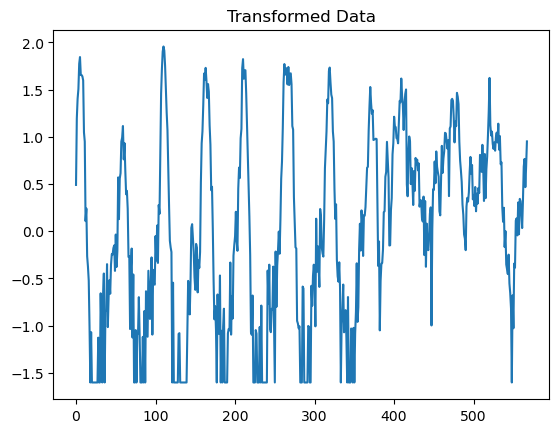

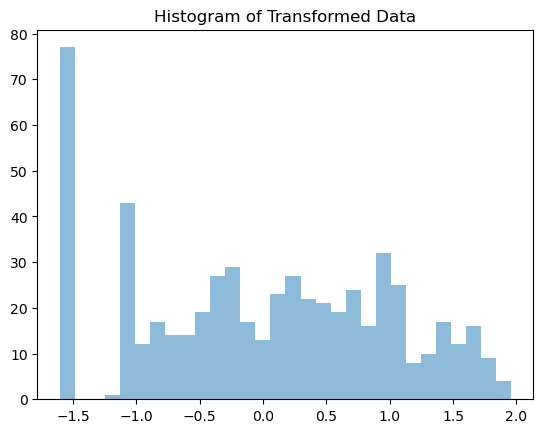

In [18]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer

# Assuming you have imported your dataset and stored it in merged_data

# Create the PowerTransformer with 'yeo-johnson' method
boxcox_transformer = PowerTransformer(method='yeo-johnson')

# Filter and select the data based on the 'georegion' condition and 'incValue' column
filtered_data = merged_data.loc[merged_data['georegion'] == "region_5", 'incValue']

# Fit and transform the filtered data
transformed_data = boxcox_transformer.fit_transform(filtered_data.values.reshape(-1, 1))

# Create a figure and axis for the transformed data
fig1, ax1 = plt.subplots()
ax1.plot(transformed_data)
ax1.set_title('Transformed Data')

# Create a figure and axis for the histogram of transformed data
fig2, ax2 = plt.subplots()
ax2.hist(transformed_data, bins=30, alpha=0.5)
ax2.set_title('Histogram of Transformed Data')

# Show the plots
plt.show()


<h3>Modelling</h3>

In [18]:
def create_lagged_features(df, column, number_of_lags, seasonal_lags=None):
    # Copy the original DataFrame to avoid modifying it
    df_lagged = df.copy()

    # Generate regular lagged features
    for lag in range(1, number_of_lags + 1):
        df_lagged[f'lag_{lag}'] = df_lagged[column].shift(lag)

    # Generate seasonal lags
    if seasonal_lags is not None:
        for season_lag in seasonal_lags:
            df_lagged[f'seasonal_lag_{season_lag}_helper'] = df_lagged[column].shift(season_lag-1)
            df_lagged[f'seasonal_lag_{season_lag}'] = df_lagged[column].shift(season_lag)

    return df_lagged


In [19]:
def autoregressive_iterative_forecast(model, initial_input, seasonal_input, n_steps):
    """
    Perform iterative forecasting using an autoregressive model.

    Args:
        model: Trained autoregressive model (e.g., MLPRegressor).
        initial_input: The initial input features (e.g., the last observation from the training set).
        n_steps: Number of future time steps to forecast.

    Returns:
        A list of forecasts, one for each future time step.
    """
    i = 0
    current_input = initial_input.copy()
    current_input = np.array(current_input)
    seasonal_input = np.array(seasonal_input)
    # print(f'Seasonal lags: {seasonal_input}')
    forecasts = []

    for _ in range(n_steps):
        # Predict the next step
        # print(f'Current_input start: {current_input}\n')
        # print(len(current_input))
        next_step_pred = model.predict(current_input.reshape(1, -1))[0]
        # print(f'\nWeek {i+1}\n')  
        # print(f'Pred: {next_step_pred}')  
        forecasts.append(next_step_pred)
        # print(f'Forecasts: {forecasts}')
        
        # Update the current input to include the new prediction
        # Roll all lags except the last one (seasonal lag)
        current_input[:-1] = np.roll(current_input[:-1], 1)
        # print(f'Current_input after roll: {current_input}\n')
        current_input[0] = next_step_pred
        
        # Update the seasonal lag (52-period lag)
        if i < 52:
            # Use the actual seasonal lag value for the first 52 weeks
            current_input[-1] = seasonal_input[i]
        else:
            # Use forecasted value for the seasonal lag after 52 weeks
            current_input[-1] = forecasts[i - 52]
        # This needs to be handled based on your specific logic
        # For example, fetching the value from 52 periods ago or some other logic
        
        # print(f'Current_input with next_step_pred: {current_input}')
        # print(f'\n {60*"#"}\n')

        i += 1

    return np.array(forecasts)

# training_cols = [col for col in df_lagged.columns if ('lag_' in col) and ('_helper' not in col)]
# X_train_cv_scaled = df_lagged[training_cols]
# print(X_train_cv_scaled.iloc[0], f'Length:{len(X_train_cv_scaled.iloc[0])}')
# print(df_lagged['seasonal_lag_52_helper'].iloc[:52])
# prediction = autoregressive_iterative_forecast(model, X_train_cv_scaled.iloc[0], df_lagged[['seasonal_lag_52_helper']], 53)

In [22]:
# Extract data
data = merged_data.loc[(merged_data['georegion'] == "region_5") & (merged_data['date'].apply(lambda x: x.year < 2020))]
# Split the data
target = 'Grippe'
y = data[target]
split = int(len(y) * 0.8)
y_train, y_test = y[:split], y[split:]

i = 0
scores_df = pd.DataFrame(columns=['RMSE', 'lags', 'seasonal_lags', 'hidden_layers', 'alpha', 'batch_size', 'activation', 'learning_rate'])

In [23]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys

# Suppress convergence warnings
# warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Define parameter configurations to assess
lags = 52 # Autoregressive lags to consider
hidden_layer_sizes = [(16, 16), (16, 16, 16)]
alphas = [0.1, 0.2] # Regularization parameter
batch_size = 32
learning_rates = [0.0001]
activations = ['relu']
seasonal = [52]

models_count = (lags-15)* len(hidden_layer_sizes) * len(alphas) * len(learning_rates) * len(activations)

# Extract data
data = merged_data.loc[(merged_data['georegion'] == "region_5") & (merged_data['date'].apply(lambda x: x.year < 2020))]
# Split the data
y = data[target]
split = int(len(y) * 0.8)
y_train, y_test = y[:split], y[split:]

i = 0
scores_df = pd.DataFrame(columns=['RMSE', 'lags', 'seasonal_lags', 'hidden_layers', 'alpha', 'batch_size', 'activation', 'learning_rate'])

# Grid search hyperparameter configurations
for lag in range(15, lags):
    for activation in activations:
        for learning_rate in learning_rates:
            for alpha in alphas:
                for hidden_layer_size in hidden_layer_sizes:
                    # Keep track of configurations and cv scores
                    model = MLPRegressor(max_iter=2000, 
                                        random_state=42, 
                                        solver='adam', 
                                        activation=activation, 
                                        hidden_layer_sizes=hidden_layer_size, 
                                        alpha=alpha, 
                                        batch_size=batch_size, 
                                        learning_rate_init=learning_rate,
                                        warm_start=False, 
                                        early_stopping=True)
                    scores = []
                    tscv = TimeSeriesSplit(n_splits=3, test_size=52)
                    fold = 0
                    
                    # Create lagged features based on the whole y_train
                    df_lagged = create_lagged_features(pd.DataFrame(y_train, columns=[target]), column=target, number_of_lags=lag, seasonal_lags=seasonal)
                    df_lagged.dropna(inplace=True)
                    
                    training_cols = [col for col in df_lagged.columns if ('lag_' in col) and ('_helper' not in col)]
                    X = df_lagged[training_cols]
                    X_seasonal = df_lagged['seasonal_lag_52_helper']
                    y = df_lagged[target]
                    # print(X)
                    # print(y)
                    
                    for train_index, val_index in tscv.split(X):
                        
                        y_train_cv, y_val = y.iloc[train_index], y.iloc[val_index]
                        X_train_cv, X_val = X.iloc[train_index], X.iloc[val_index]
                        X_seasonal_train, X_seasonal_val = X_seasonal.iloc[train_index], X_seasonal.iloc[val_index]

                        # Take the first row of X_train_cv (the oldest lags)
                        oldest_lags = X_train_cv.iloc[0, 1:].values.reshape(1, -1)

                        # Concatenate y_train_cv with the oldest lags
                        combined_data = np.vstack((y_train_cv.values.reshape(-1, 1), oldest_lags.T))

                        # Fit the PowerTransformer and StandardScaler on the available lags in the training data (incl. lags in first row of lag df_train)
                        pt = PowerTransformer(method='yeo-johnson')
                        stdscaler = StandardScaler()
                        combined_data_transformed = pt.fit_transform(combined_data)
                        stdscaler.fit(combined_data_transformed)
                        
                        # Apply Transform to the entire y_train_cv
                        y_train_cv_transformed = pt.transform(y_train_cv.values.reshape(-1, 1)).flatten()
                        y_val_transformed = pt.transform(y_val.values.reshape(-1, 1)).flatten()

                        # Apply the PowerTransformer to each lagged feature in X_train_cv and X_val
                        X_train_cv_transformed = X_train_cv.apply(lambda column: pt.transform(column.values.reshape(-1, 1)).flatten())
                        X_val_transformed = X_val.apply(lambda column: pt.transform(column.values.reshape(-1, 1)).flatten())
                        X_seasonal_train_trans = pt.transform(X_seasonal_train.values.reshape(-1, 1)).flatten()
                        X_seasonal_val_trans = pt.transform(X_seasonal_val.values.reshape(-1, 1)).flatten()

                        
                        # Apply StandardScaler()
                        y_train_cv_scaled = stdscaler.transform(y_train_cv_transformed.reshape(-1, 1)).flatten()
                        y_val_scaled = stdscaler.transform(y_val_transformed.reshape(-1, 1)).flatten()
                        X_train_cv_scaled = X_train_cv_transformed.apply(lambda column: stdscaler.transform(column.values.reshape(-1, 1)).flatten())
                        X_val_scaled = X_val_transformed.apply(lambda column: stdscaler.transform(column.values.reshape(-1, 1)).flatten())
                        X_seasonal_train_scaled = stdscaler.transform(X_seasonal_train_trans.reshape(-1, 1)).flatten()
                        X_seasonal_val_scaled = stdscaler.transform(X_seasonal_val_trans.reshape(-1, 1)).flatten()

                        ######################
                        # NOTE: PLOT VALIDATION AND TRAINING LOSSES - Adjust max_iter to 1 and set warm_start = True to enable

                        # training_losses = []
                        # validation_losses = []

                        # for epoch in range(1000):  # Adjust the number of epochs as needed
                        #     model.fit(X_train_cv_scaled.values, y_train_cv_scaled)

                        #     # Store training loss from the last iteration
                        #     training_losses.append(model.loss_curve_[-1])

                        #     # Compute and store validation loss
                        #     val_predictions = model.predict(X_val_scaled.values)
                        #     val_loss = mean_squared_error(y_val_scaled, val_predictions)
                        #     validation_losses.append(val_loss)
                        
                        # if fold == 2:
                        #     plt.plot(training_losses, label='Training Loss')
                        #     # If you have validation loss, plot it here
                        #     plt.plot(validation_losses, label='Validation Loss')

                        #     plt.title('Learning Curve')
                        #     plt.xlabel('Epochs')
                        #     plt.ylabel('Loss')
                        #     plt.title(f'Lags: {lag}, Learning-rate: {learning_rate}, alpha: {alpha}, hidden layers: {hidden_layer_size}')
                        #     plt.legend()
                        #     plt.show()

                        #######################

                        # Fit model
                        model.fit(X_train_cv_scaled.values, y_train_cv_scaled)
                        # loss_values = model.loss_curve_
                        
                        # Make iterative forecasts (NOTE: train and val splits are numpy arrays, seasonal helper columns necessary for updating of seasonal lag)
                        # print(f'X_val_scaled: {X_val_scaled}')
                        # print(f'X_val_scaled: {X_val_scaled.iloc[0]}')
                        prediction = autoregressive_iterative_forecast(model, X_val_scaled.iloc[0], X_seasonal_val_scaled, len(y_val_scaled))
                        y_hat_train = autoregressive_iterative_forecast(model, X_train_cv_scaled.iloc[0], X_seasonal_train_scaled, len(y_train_cv_scaled))
                        prediction = np.array(prediction).flatten()
                        y_hat_train = np.array(y_hat_train).flatten()

                        #######################
                        # NOTE: UNCOMMENT FOR PLOTS OF VALIDATION - Plot actual vs predicted values
                        # plt.figure(figsize=(10, 6))
                        # plt.plot(range(len(y_train_cv_scaled)), y_train_cv_scaled, label='Training Actual', color='blue')
                        # plt.plot(range(len(y_train_cv_scaled), len(y_train_cv_scaled) + len(y_val_scaled)), y_val_scaled, label='Validation Actual', color='blue')
                        # plt.plot(range(len(y_train_cv_scaled), len(y_train_cv_scaled) + len(y_val_scaled)), prediction, label='Validation Predicted', color='red', linestyle='--')
                        # plt.plot(range(len(y_train_cv_scaled)), y_hat_train, label='Train-Set Prediction', color='orange', linestyle='--')
                        
                        # plt.title(f'Lag: {lag}; Fold {fold+1} Predictions vs Actual')
                        # plt.xlabel('Time')
                        # plt.ylabel('Scaled Value')
                        # plt.legend()
                        # plt.show()
                        ########################

                        rmse = mean_squared_error(y_val_scaled, prediction, squared=False)

                        scores.append(rmse)
                        fold += 1
                    
                    # Fill in parameters and score for each configuration 
                    scores_df.loc[i, 'lags'] = lag
                    scores_df.loc[i, 'seasonal_lags'] = seasonal
                    scores_df.loc[i, 'hidden_layers'] = hidden_layer_size
                    scores_df.loc[i, 'alpha'] = alpha
                    scores_df.loc[i, 'batch_size'] = batch_size
                    scores_df.loc[i, 'activation'] = activation
                    scores_df.loc[i, 'learning_rate'] = learning_rate
                    scores_df.loc[i, 'RMSE'] = np.mean(scores)
                    print(f'{i}/{models_count}: {(i/models_count)*100:.2f}%')
                    i += 1

0/148: 0.00%
1/148: 0.68%
2/148: 1.35%
3/148: 2.03%
4/148: 2.70%
5/148: 3.38%
6/148: 4.05%
7/148: 4.73%
8/148: 5.41%
9/148: 6.08%
10/148: 6.76%
11/148: 7.43%
12/148: 8.11%
13/148: 8.78%
14/148: 9.46%
15/148: 10.14%
16/148: 10.81%
17/148: 11.49%
18/148: 12.16%
19/148: 12.84%
20/148: 13.51%
21/148: 14.19%
22/148: 14.86%
23/148: 15.54%
24/148: 16.22%
25/148: 16.89%
26/148: 17.57%
27/148: 18.24%
28/148: 18.92%
29/148: 19.59%
30/148: 20.27%
31/148: 20.95%
32/148: 21.62%
33/148: 22.30%
34/148: 22.97%
35/148: 23.65%
36/148: 24.32%
37/148: 25.00%
38/148: 25.68%
39/148: 26.35%
40/148: 27.03%
41/148: 27.70%
42/148: 28.38%
43/148: 29.05%
44/148: 29.73%
45/148: 30.41%
46/148: 31.08%
47/148: 31.76%
48/148: 32.43%
49/148: 33.11%
50/148: 33.78%
51/148: 34.46%
52/148: 35.14%
53/148: 35.81%
54/148: 36.49%
55/148: 37.16%
56/148: 37.84%
57/148: 38.51%
58/148: 39.19%
59/148: 39.86%
60/148: 40.54%
61/148: 41.22%
62/148: 41.89%
63/148: 42.57%
64/148: 43.24%
65/148: 43.92%
66/148: 44.59%
67/148: 45.27%
68/14

In [27]:
scores_df['RMSE'] = pd.to_numeric(scores_df['RMSE'])
# Best parameters and score
best_config_index = scores_df['RMSE'].idxmin()  # This gets the index of the minimum RMSE
best_config = scores_df.loc[best_config_index]  # Use the index to access the row
best_score = best_config['RMSE']
print(f"Best parameters: {best_config}")
print(f"Best score (RMSE): {best_score}")

Best parameters: RMSE             0.760004
lags                   25
seasonal_lags        [52]
hidden_layers    (16, 16)
alpha                 0.2
batch_size             32
activation           relu
learning_rate      0.0001
Name: 42, dtype: object
Best score (RMSE): 0.7600036598458831


In [120]:
scores_df.sort_values(by='RMSE').head(20)

,RMSE,lags,seasonal_lags,hidden_layers,alpha,batch_size,activation,learning_rate
42,0.760004,25,[52],"(16, 16)",0.2,32,relu,0.0001
40,0.763214,25,[52],"(16, 16)",0.1,32,relu,0.0001
64,0.789401,31,[52],"(16, 16)",0.1,32,relu,0.0001
66,0.794368,31,[52],"(16, 16)",0.2,32,relu,0.0001
75,0.799721,33,[52],"(16, 16, 16)",0.2,32,relu,0.0001
62,0.804587,30,[52],"(16, 16)",0.2,32,relu,0.0001
73,0.805873,33,[52],"(16, 16, 16)",0.1,32,relu,0.0001
60,0.808277,30,[52],"(16, 16)",0.1,32,relu,0.0001
131,0.809337,47,[52],"(16, 16, 16)",0.2,32,relu,0.0001
16,0.817101,19,[52],"(16, 16)",0.1,32,relu,0.0001


In [121]:
best_config = scores_df.loc[73]

In [122]:
best_lag = best_config.values[1]
best_seasonal_lag = best_config.values[2]
best_hidden_layers = best_config.values[3]
best_alpha = best_config.values[4]
best_batch_size = best_config.values[5]
best_activation = best_config.values[6]
best_learning_rate = best_config.values[7]

In [123]:
best_learning_rate

0.0001

In [124]:
# Extract data
data = merged_data.loc[(merged_data['georegion'] == "region_5") & (merged_data['date'].apply(lambda x: x.year < 2020))]
# Split the data
y = data[target]

# Create lagged features based on the whole y
df_lagged = create_lagged_features(pd.DataFrame(y, columns=[target]), column=target, number_of_lags=best_lag, seasonal_lags=best_seasonal_lag)

split = int(len(y) * 0.8)
# NOTE: SPLIT BEFORE DROPPING TO AVOID DATA LEAKAGE
df_lagged_train = df_lagged.iloc[:split]
df_lagged_train = df_lagged_train.dropna()
df_lagged_test = df_lagged.iloc[split:]

# Extract training columns and output variable from dataframe
training_cols = [col for col in df_lagged.columns if ('lag_' in col) and ('helper' not in col)]
X_train = df_lagged_train[training_cols]
y_train = df_lagged_train[target]
X_test = df_lagged_test[training_cols]
y_test = df_lagged_test[target]

# Columns required for rolling of seasonal lag in iterative autoregressive forecast
X_train_seasonal = df_lagged_train['seasonal_lag_52_helper']
X_test_seasonal = df_lagged_test['seasonal_lag_52_helper']

# Create combined data to fit transform on all available historical lags in training set
oldest_lags = X_train.iloc[0, 1:].values.reshape(1, -1) # Take the first row of X_train_cv (the oldest lags)
combined_data = np.vstack((y_train.values.reshape(-1, 1), oldest_lags.T)) # Concatenate y_train_cv with the oldest lags

# Fit Yeo-Johnson Transform on combined data
pt = PowerTransformer(method='yeo-johnson')
stdscaler = StandardScaler()
combined_data_transformed = pt.fit_transform(combined_data)
stdscaler.fit(combined_data_transformed)

# Apply transform and scaling to train and test sets
y_train_transformed = pt.transform(y_train.values.reshape(-1, 1)).flatten()
y_test_transformed = pt.transform(y_test.values.reshape(-1, 1)).flatten()
X_train_transformed = X_train.apply(lambda x: pt.transform(x.values.reshape(-1, 1)).flatten())
X_test_transformed = X_test.apply(lambda x: pt.transform(x.values.reshape(-1, 1)).flatten())
# X_train_transformed = X_train.apply(lambda x: pt.transform(x))
# X_test_transformed = X_test.apply(lambda x: pt.transform(x.values.reshape(-1, 1))).flatten()
X_train_seasonal_trans = pt.transform(X_train_seasonal.values.reshape(-1, 1)).flatten()
X_test_seasonal_trans = pt.transform(X_test_seasonal.values.reshape(-1, 1)).flatten()

# Apply StandardScaler
y_train_scaled = stdscaler.transform(y_train_transformed.reshape(-1, 1)).flatten()
y_test_scaled = stdscaler.transform(y_test_transformed.reshape(-1, 1)).flatten()
X_train_scaled = X_train_transformed.apply(lambda x: stdscaler.transform(x.values.reshape(-1, 1)).flatten())
X_test_scaled = X_test_transformed.apply(lambda x: stdscaler.transform(x.values.reshape(-1, 1)).flatten())
X_train_seasonal_scaled = stdscaler.transform(X_train_seasonal_trans.reshape(-1, 1)).flatten()
X_test_seasonal_scaled = stdscaler.transform(X_test_seasonal_trans.reshape(-1, 1)).flatten()

# Initialize the final model configuration
final_model = MLPRegressor(max_iter=1000, 
                    random_state=42, 
                    solver='adam', 
                    activation=best_activation, 
                    hidden_layer_sizes=(best_hidden_layers), 
                    alpha=best_alpha, 
                    batch_size=best_batch_size, 
                    learning_rate_init=best_learning_rate)

# Train final model
final_model.fit(X_train_scaled.values, y_train_scaled) 

# Forecast for the length of the test set
forecasts = autoregressive_iterative_forecast(final_model, X_test_scaled.iloc[0], X_test_seasonal_scaled,len(y_test_scaled))
y_hat_train = autoregressive_iterative_forecast(final_model, X_train_scaled.iloc[0], X_train_seasonal_scaled, len(y_train))

forecasts = stdscaler.inverse_transform(forecasts.reshape(-1, 1))
forecasts = pt.inverse_transform(forecasts.reshape(-1, 1))
y_hat_train = stdscaler.inverse_transform(y_hat_train.reshape(-1, 1))
y_hat_train = pt.inverse_transform(y_hat_train.reshape(-1, 1))

# Evaluate the forecasts against the actual y_test values
rmse = mean_squared_error(y_test, forecasts, squared=False)

print(f"The RMSE for the forecasts is: {rmse:.3f}")

The RMSE for the forecasts is: 2.447


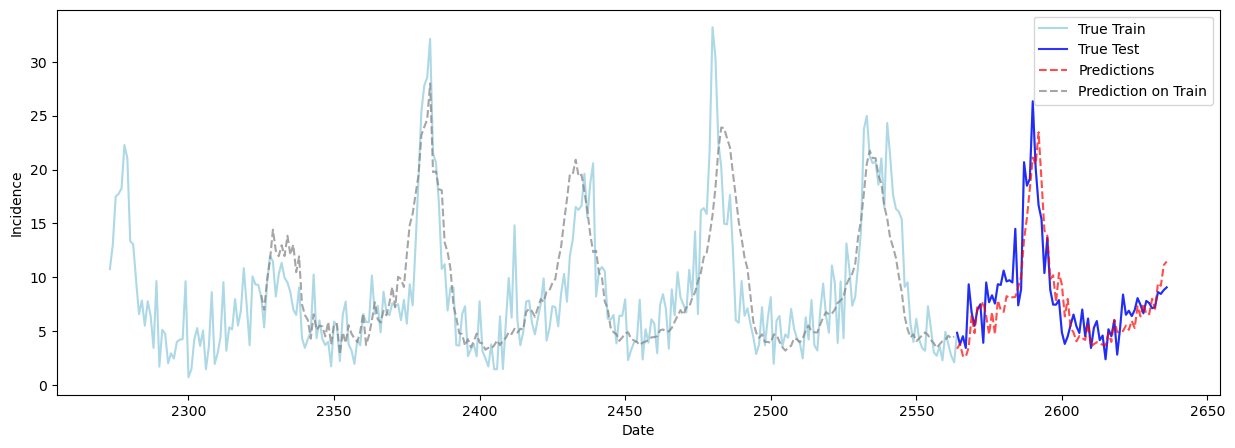

In [125]:
# Plot the results
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the true values
# ax.plot(plot['incValue'])

ax.plot(df_lagged[target], label="True Train", alpha=1, color='lightblue')
ax.plot(y_test.index, y_test, label="True Test", alpha=0.8, color='blue')
ax.plot(y_test.index, forecasts, label='Predictions', alpha=0.7, color='red', linestyle='--')
ax.plot(y_train.index, y_hat_train, label='Prediction on Train', alpha=0.7, color='grey', linestyle='--')


# Add labels and legend
ax.set_xlabel("Date")
ax.set_ylabel("Incidence")
ax.legend()

<h1>Backup --------------</h1>

<h3>Feature Engineering</h3>

In [20]:
# from sklearn.neural_network import MLPRegressor
# from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.metrics import mean_squared_error

In [21]:
# def autoregressive_iterative_forecast(model, initial_input, n_steps):
#     """
#     Perform iterative forecasting using an autoregressive model.

#     Args:
#         model: Trained autoregressive model (e.g., MLPRegressor).
#         initial_input: The initial input features (e.g., the last observation from the training set).
#         n_steps: Number of future time steps to forecast.

#     Returns:
#         A list of forecasts, one for each future time step.
#     """
#     current_input = initial_input.copy()
#     forecasts = []

#     for _ in range(n_steps):
#         # Predict the next step
#         next_step_pred = model.predict(current_input.reshape(1, -1))[0]
#         forecasts.append(next_step_pred)

#         # Update the current input to include the new prediction
#         current_input = np.roll(current_input, -1)
#         current_input[-1] = next_step_pred

#     return np.array(forecasts)


In [22]:
# def create_lagged_features(df, column, number_of_lags=4, seasonal_lags=[52]):
#     # Define a helper function to apply within each group
#     def add_lags(group):
#         # Create a dictionary for the lagged features
#         lags = {f'lag_{i}': group[column].shift(i) for i in range(1, number_of_lags + 1)}
#         for seasonal_lag in seasonal_lags:
#             lags.update({f'seasonal_lag_{i}': group[column].shift(i) for i in range(seasonal_lag - 2, seasonal_lag + 3)})
#         # Return the original column along with the lagged features
#         return pd.concat([group[column], pd.DataFrame(lags, index=group.index)], axis=1)

#     # Group by 'georegion' and apply the lagging within each group
#     new_df = df.groupby('georegion', group_keys=False).apply(add_lags)

#     # Reset index to flatten the dataframe structure after grouping
#     new_df.reset_index(drop=True, inplace=True)

#     return new_df


# data = merged_data.loc[(merged_data['georegion'] == "region_5") & (merged_data['date'].apply(lambda x: x.year < 2020))]

# df_lagged = create_lagged_features(data, column='incValue')
# df_lagged.dropna(inplace=True)
# training_cols = [col for col in df_lagged.columns if 'lag_' in col]
# X = df_lagged[training_cols]
# y = df_lagged['incValue']

In [23]:
# def create_lagged_features(df, column, number_of_lags=4):
#     # Define a helper function to apply within each group
#     def add_lags(group):
#         # Create a dictionary for the lagged features
#         lags = {f'lag_{i}': group[column].shift(i) for i in range(1, number_of_lags + 1)}
#         # Return the original column along with the lagged features
#         return pd.concat([group[column], pd.DataFrame(lags, index=group.index)], axis=1)

#     # Group by 'georegion' and apply the lagging within each group
#     new_df = df.groupby('georegion', group_keys=False).apply(add_lags)

#     # Reset index to flatten the dataframe structure after grouping
#     new_df.reset_index(drop=True, inplace=True)

#     return new_df

# data = merged_data.loc[(merged_data['georegion'] == "region_5") & (merged_data['date'].apply(lambda x: x.year < 2020))]

# df_lagged = create_lagged_features(data, column='incValue')
# df_lagged.dropna(inplace=True)
# training_cols = [col for col in df_lagged.columns if 'lag_' in col]
# X = df_lagged[training_cols]
# y = df_lagged['incValue']


<h3>Backups of the first versions</h3>

In [24]:
# data = merged_data.loc[(merged_data['georegion'] == "region_5") & (merged_data['date'].apply(lambda x: x.year < 2020))]

# # Define parameter configurations to assess
# lags = 51 # Autoregressive lags to consider
# hidden_layer_sizes = [(32,), (32, 32)]
# alphas = [0.0001, 0.001, 0.01] # Regularization parameter
# batch_sizes = [32]
# learning_rates = [0.001, 0.01]
# activations = ['relu']
# seasonal = [[52]]

# models_count = (lags-30) * len(hidden_layer_sizes) * len(alphas) * len(batch_sizes) * len(learning_rates) * len(activations) * len(seasonal)

# i = 0
# scores_df = pd.DataFrame(columns=['RMSE', 'lags', 'seasonal_lags', 'hidden_layers', 'alpha', 'batch_size', 'activation', 'learning_rate'])
# # Grid search hyperparameter configurations
# for lag in range(30, lags):
#     for seasonal_lags in seasonal:
#         # Create lagged features
#         df_lagged = create_lagged_features(data, column='incValue', number_of_lags=lags, seasonal_lags=seasonal_lags)
#         df_lagged.dropna(inplace=True)
#         training_cols = [col for col in df_lagged.columns if 'lag_' in col]
#         X = df_lagged[training_cols]
#         y = df_lagged['incValue']

#         # Split the data
#         split = int(len(y) * 0.8)
#         X_train, X_test = X[:split], X[split:]
#         y_train, y_test = y[:split], y[split:]

#         # Scale the inputs
#         scaler_X = MinMaxScaler()
#         X_train_scaled = scaler_X.fit_transform(X_train)
#         X_test_scaled = scaler_X.transform(X_test)  # Use the same scaler as for X_train

#         # Scale the target
#         scaler_y = MinMaxScaler()
#         y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()  # Reshape to 1D array
#         y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()        # Reshape to 1D array

#         # Keep track of configurations and cv scores

#         for hidden_layers in hidden_layer_sizes:
#             for learning_rate in learning_rates:
#                 for activation in activations:
#                     for alpha in alphas:
#                         for batch_size in batch_sizes:
#                             model = MLPRegressor(max_iter=1000, 
#                                                 random_state=42, 
#                                                 solver='adam', 
#                                                 activation=activation, 
#                                                 hidden_layer_sizes=hidden_layers, 
#                                                 alpha=alpha, 
#                                                 batch_size=batch_size, 
#                                                 learning_rate_init=learning_rate,
#                                                 early_stopping=True, 
#                                                 validation_fraction=0.1, 
#                                                 n_iter_no_change=100,
#                                                 tol=1e-3)
#                             scores = []
#                             tscv = TimeSeriesSplit(n_splits=3)
#                             for train_index, val_index in tscv.split(X_train):
#                                 # Create rolling windows
#                                 X_train_cv, X_val = X_train_scaled[train_index], X_train_scaled[val_index]
#                                 y_train_cv, y_val = y_train_scaled[train_index], y_train_scaled[val_index]
                                
#                                 # Fit model
#                                 model.fit(X_train_cv, y_train_cv)
                                
#                                 predictions = autoregressive_iterative_forecast(model, X_train_cv[-1], len(y_val))
                                
#                                 rmse = mean_squared_error(y_val, predictions, squared=False)
#                                 scores.append(rmse)
                            
#                             # Fill in parameters and score for each configuration 
#                             scores_df.loc[i, 'lags'] = lag
#                             scores_df.loc[i, 'seasonal_lags'] = seasonal_lags
#                             scores_df.loc[i, 'hidden_layers'] = hidden_layers
#                             scores_df.loc[i, 'alpha'] = alpha
#                             scores_df.loc[i, 'batch_size'] = batch_size
#                             scores_df.loc[i, 'activation'] = activation
#                             scores_df.loc[i, 'learning_rate'] = learning_rate
#                             scores_df.loc[i, 'RMSE'] = np.mean(scores)
#                             print(f'{i}/{models_count}: {(i/models_count)*100:.2f}%')
#                             i += 1

In [25]:
# data = merged_data.loc[(merged_data['georegion'] == "region_5") & (merged_data['date'].apply(lambda x: x.year < 2020))]

# # Define parameter configurations to assess
# lags = 51 # Autoregressive lags to consider
# hidden_layer_sizes = [(32,), (32, 32)]
# alphas = [0.0001, 0.001, 0.01] # Regularization parameter
# batch_sizes = [32]
# learning_rates = [0.001, 0.01]
# activations = ['relu']
# seasonal = [[52]]

# models_count = (lags-30) * len(hidden_layer_sizes) * len(alphas) * len(batch_sizes) * len(learning_rates) * len(activations) * len(seasonal)

# i = 0
# scores_df = pd.DataFrame(columns=['RMSE', 'lags', 'seasonal_lags', 'hidden_layers', 'alpha', 'batch_size', 'activation', 'learning_rate'])
# # Grid search hyperparameter configurations
# for lag in range(30, lags):
#     # Create lagged features
#     df_lagged = create_lagged_features(data, column='incValue', number_of_lags=lags, seasonal_lags=seasonal_lags)
#     df_lagged.dropna(inplace=True)
#     training_cols = [col for col in df_lagged.columns if 'lag_' in col]
#     X = df_lagged[training_cols]
#     y = df_lagged['incValue']

#     # Split the data
#     split = int(len(y) * 0.8)
#     X_train, X_test = X[:split], X[split:]
#     y_train, y_test = y[:split], y[split:]

#     # Scale the inputs
#     scaler_X = MinMaxScaler()
#     X_train_scaled = scaler_X.fit_transform(X_train)
#     X_test_scaled = scaler_X.transform(X_test)  # Use the same scaler as for X_train

#     # Scale the target
#     scaler_y = MinMaxScaler()
#     y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()  # Reshape to 1D array
#     y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()        # Reshape to 1D array

#     # Keep track of configurations and cv scores

#     for hidden_layers in hidden_layer_sizes:
#         for learning_rate in learning_rates:
#             for activation in activations:
#                 for alpha in alphas:
#                     for batch_size in batch_sizes:
#                         model = MLPRegressor(max_iter=1000, 
#                                             random_state=42, 
#                                             solver='adam', 
#                                             activation=activation, 
#                                             hidden_layer_sizes=hidden_layers, 
#                                             alpha=alpha, 
#                                             batch_size=batch_size, 
#                                             learning_rate_init=learning_rate,
#                                             early_stopping=True, 
#                                             validation_fraction=0.1, 
#                                             n_iter_no_change=100,
#                                             tol=1e-3)
#                         scores = []
#                         tscv = TimeSeriesSplit(n_splits=3)
#                         for train_index, val_index in tscv.split(X_train):
#                             # Create rolling windows
#                             X_train_cv, X_val = X_train_scaled[train_index], X_train_scaled[val_index]
#                             y_train_cv, y_val = y_train_scaled[train_index], y_train_scaled[val_index]
                            
#                             # Fit model
#                             model.fit(X_train_cv, y_train_cv)
#                             predictions = []
#                             for t in range(len(y_val)):
#                                 one_step_prediction = autoregressive_iterative_forecast(model, X_train_cv[-1] if t == 0 else X_val[t-1], 1)
#                                 predictions.append(one_step_prediction)
                            
#                             rmse = mean_squared_error(y_val, predictions, squared=False)
#                             scores.append(rmse)
                        
#                         # Fill in parameters and score for each configuration 
#                         scores_df.loc[i, 'lags'] = lag
#                         scores_df.loc[i, 'seasonal_lags'] = seasonal_lags
#                         scores_df.loc[i, 'hidden_layers'] = hidden_layers
#                         scores_df.loc[i, 'alpha'] = alpha
#                         scores_df.loc[i, 'batch_size'] = batch_size
#                         scores_df.loc[i, 'activation'] = activation
#                         scores_df.loc[i, 'learning_rate'] = learning_rate
#                         scores_df.loc[i, 'RMSE'] = np.mean(scores)
#                         print(f'{i}/{models_count}: {(i/models_count)*100:.2f}%')
#                         i += 1

In [26]:
# NOTE BACKUP
# def autoregressive_iterative_forecast(model, initial_input, n_steps):
#     """
#     Perform iterative forecasting using an autoregressive model.

#     Args:
#         model: Trained autoregressive model (e.g., MLPRegressor).
#         initial_input: The initial input features (e.g., the last observation from the training set).
#         n_steps: Number of future time steps to forecast.

#     Returns:
#         A list of forecasts, one for each future time step.
#     """
#     current_input = initial_input.copy()
#     forecasts = []

#     for _ in range(n_steps):
#         # Predict the next step
#         next_step_pred = model.predict(current_input.reshape(1, -1))[0]
#         forecasts.append(next_step_pred)

#         # Update the current input to include the new prediction
#         current_input = np.roll(current_input, -1)
#         current_input[-1] = next_step_pred

#     return np.array(forecasts)

In [143]:
# from sklearn.preprocessing import PowerTransformer
# from sklearn.preprocessing import StandardScaler
# from sklearn.neural_network import MLPRegressor
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import TimeSeriesSplit
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np

# # Define parameter configurations to assess
# lags = 52 # Autoregressive lags to consider
# hidden_layer_size = (32, 32)
# alpha = 0.001 # Regularization parameter
# batch_size = 32
# learning_rate = 0.01
# activations = 'relu'
# seasonal = [52]
# models_count = lags

# # Extract data
# data = merged_data.loc[(merged_data['georegion'] == "region_5") & (merged_data['date'].apply(lambda x: x.year < 2020))]
# # Split the data
# y = data['incValue']
# split = int(len(y) * 0.8)
# y_train, y_test = y[:split], y[split:]

# i = 0
# scores_df = pd.DataFrame(columns=['RMSE', 'lags', 'seasonal_lags', 'hidden_layers', 'alpha', 'batch_size', 'activation', 'learning_rate'])
# # Grid search hyperparameter configurations
# for lag in range(1, lags):
    
#     # Apply Yeo-Johnson Transform
#     pt = PowerTransformer(method='yeo-johnson')
#     y_train_transformed = pt.fit_transform(y_train.values.reshape(-1, 1)).flatten()  # Flatten to 1D array

#     # Create lagged features based on the transformed y
#     df_lagged = create_lagged_features(pd.DataFrame(y_train_transformed, columns=['incValue']), column='incValue', number_of_lags=lag, seasonal_lags=seasonal)
#     df_lagged.dropna(inplace=True)
    
#     training_cols = [col for col in df_lagged.columns if ('lag_' in col) and ('_helper' not in col)]
#     X = df_lagged[training_cols]
#     y = df_lagged['incValue']
#     print(X)
#     print(y)
#     # Keep track of configurations and cv scores
#     model = MLPRegressor(max_iter=1000, 
#                         random_state=42, 
#                         solver='adam', 
#                         activation=activations, 
#                         hidden_layer_sizes=hidden_layer_size, 
#                         alpha=alpha, 
#                         batch_size=batch_size, 
#                         learning_rate_init=learning_rate)
#     scores = []
#     tscv = TimeSeriesSplit(n_splits=5)
#     fold = 0
#     for train_index, val_index in tscv.split(X):

#         X_train_cv, X_val = X.iloc[train_index], X.iloc[val_index]
#         y_train_cv, y_val = y.iloc[train_index], y.iloc[val_index]
        
#         # Apply scaling within each fold for y
#         scaler_y = StandardScaler()
#         y_train_cv_scaled = scaler_y.fit_transform(y_train_cv.values.reshape(-1, 1)).flatten()
#         y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()

#         scaler_X = StandardScaler()
#         X_train_cv_scaled = scaler_X.fit_transform(X_train_cv)
#         X_val_scaled = scaler_X.transform(X_val)
        
#         # Fit model
#         model.fit(X_train_cv_scaled, y_train_cv_scaled)
#         # loss_values = model.loss_curve_
        
#         # Make iterative forecasts (NOTE: train and val splits are numpy arrays, seasonal helper columns necessary for updating of seasonal lag)
#         prediction = autoregressive_iterative_forecast(model, X_val_scaled[0], df_lagged['seasonal_lag_52_helper'].iloc[val_index], len(y_val_scaled))
#         y_hat_train = autoregressive_iterative_forecast(model, X_train_cv_scaled[0], df_lagged['seasonal_lag_52_helper'].iloc[train_index], len(y_train_cv_scaled))
#         prediction = np.array(prediction).flatten()
#         y_hat_train = np.array(y_hat_train).flatten()

#         # NOTE: UNPLOT FOR PLOTS OF VALIDATION - Plot actual vs predicted values
#         plt.figure(figsize=(10, 6))
#         plt.plot(range(len(y_train_cv_scaled)), y_train_cv_scaled, label='Training Actual', color='blue')
#         plt.plot(range(len(y_train_cv_scaled), len(y_train_cv_scaled) + len(y_val_scaled)), y_val_scaled, label='Validation Actual', color='blue')
#         plt.plot(range(len(y_train_cv_scaled), len(y_train_cv_scaled) + len(y_val_scaled)), prediction, label='Validation Predicted', color='red', linestyle='--')
#         plt.plot(range(len(y_train_cv_scaled)), y_hat_train, label='Train-Set Prediction', color='orange', linestyle='--')
        
#         plt.title(f'Lag: {lag}; Fold {fold+1} Predictions vs Actual')
#         plt.xlabel('Time')
#         plt.ylabel('Scaled Value')
#         plt.legend()
#         plt.show()
        
#         # plt.plot(loss_values, label='Training Loss')
#         # # If you have validation loss, plot it here
#         # # plt.plot(validation_loss_values, label='Validation Loss')

#         # plt.title('Learning Curve')
#         # plt.xlabel('Epochs')
#         # plt.ylabel('Loss')
#         # plt.legend()
#         # plt.show()
        
#         rmse = mean_squared_error(y_val_scaled, prediction, squared=False)

#         scores.append(rmse)
#         fold += 1
    
#     # Fill in parameters and score for each configuration 
#     scores_df.loc[i, 'lags'] = lag
#     scores_df.loc[i, 'seasonal_lags'] = seasonal
#     scores_df.loc[i, 'hidden_layers'] = hidden_layer_size
#     scores_df.loc[i, 'alpha'] = alpha
#     scores_df.loc[i, 'batch_size'] = batch_size
#     scores_df.loc[i, 'activation'] = activations
#     scores_df.loc[i, 'learning_rate'] = learning_rate
#     scores_df.loc[i, 'RMSE'] = np.mean(scores)
#     print(f'{i}/{models_count}: {(i/models_count)*100:.2f}%')
#     i += 1

<h4>------------- End Backup</h4>

<h3>Exogenous Variables</h3>